##  GreenBuildings3: Building A Predictive Model With ML-Flow

------

## Contents

__[1. Introduction](#intro)__

__[2. Intro To MLflow](#mlflow-one)__

__[3. Scikit-Learn: Linear Regression & Logging A Simple Run](#mlflow-two)__

__[5. XGBoost: Gradient Boosted Trees & Logging Nested Runs](#mlflow-three)__

__[6. MLflow: Model Serving And Docker](#mlflow-four)__

__[6. Conclusions ](#fifth-bullet)__


--------------

## Introduction <a class="anchor" id="intro"></a>
-------------



## Working With MLflow <a class="anchor" id="mlflow"></a>

[MLflow](https://mlflow.org/) is an open source tool to make machine learning easier and more reproduciable made by [Databricks](https://databricks.com/) (the same people who created [Apache Spark](https://spark.apache.org/)).  There are many components to MLflow, but the two I will be looking at are,

- MLflow Tracking : A tool for logging modeling experiments
- MLflow Models : A tool for serving models as REST APIs

I will stick to using MLflow locally instead of a production set up. You can start the Web UI with the command:

    mlflow ui --host=0.0.0.0 --port=5050

Then going to the website http://0.0.0.0:5050 in your web broswer where we will see the following:


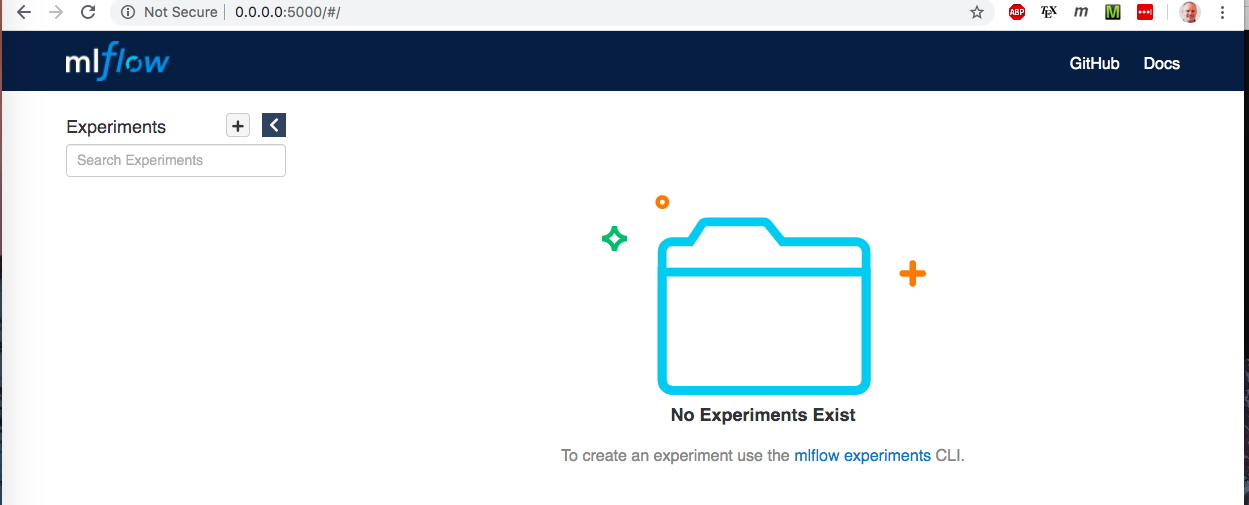


We can see the generic MLflow website without any modeling experiment data. This will change soon enough. We can collect modeling information into "*experiments*" that will contain "*runs*", i.e. information on builds of models. Each run could be one model or a series of different model each trained with different parameter values.  In this way MLflow tracking is great for organizing and maintaining as much information about model development as you like.  Locally, MLflow will create a file directory called,

    mlruns
    
that will be housed in the same path that the `mlflow server` was run in.

    export MLFLOW_TRACKING_URI=`pwd`/mlruns/

We'll get into more details on MLflow later, but for now let's import it along with some other basic libraries:

In [1]:
import mlflow
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

We can see the mlflow tracking url to see where all the data for MLflow will be stored (i.e. where `mlruns` directory is):

In [2]:
mlflow.get_tracking_uri()

'file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns'

Now let's create an experiment for this project and get started!  

In [3]:
try:
    mlflow.create_experiment("greenbuildings")
    experiment = mlflow.get_experiment_by_name("greenbuildings")
except:
    experiment = mlflow.get_experiment_by_name("greenbuildings")

We can see that we get an "experiment" that has a number of attributes:

In [4]:
print(experiment)

<Experiment: artifact_location='file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns/1', experiment_id='1', lifecycle_stage='active', name='greenbuildings', tags={}>


These attributes include:

- **artifact_location** (where the metadata + models will be stored)
- **experiment_id** (to help us track the experiment)
- **lifestyle_stage**
- **name**
- **tag**


The experiment id is an important attribute and we will be used quite frequently to know where to log and organize where the different runs are kept. We set it next:

In [5]:
exp_id = experiment.experiment_id

Let's move on to building our first model for predicting green house gas emission of buildings and create an rest API out of it.

## Scikit-Learn: Linear Regression <a class="anchor" id="fourth-bullet"></a>

Let's build a predictive model for green house gas emissions by multifamily homes and offices  in New York City.  We'll do this at first using a simple linear regression model.  While not the best in terms of predictive performance it is often a best first step since it allows one to interpet the effect each feature has on the predicted green house gas emissions.  We'll discuss this more later, but for now lets import our data from [Google BigQuery](https://cloud.google.com/bigquery) using the set up from the [previous posts](http://michael-harmon.com/blog/GreenBuildings1.html):

In [6]:
from google.oauth2 import service_account
from google.cloud import bigquery
import json
import pandas_gbq 


credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project     = credentials.project_id

In [7]:
df = pandas_gbq.read_gbq("""
SELECT  
    CAST(Energy_Star AS INT64) AS Energy_Star,
    Site_EUI,
    NGI,
    EI,
    GHGI,
    CAST(Residential AS INT64) AS Residential,
FROM 
    db_gb.clean_data
""")

Downloading: 100%|██████████| 9542/9542 [00:01<00:00, 9158.72rows/s]


And get the target variable and predictors:

In [8]:
X = df.drop("GHGI",axis=1)
Y = df["GHGI"] 

Let's remind ourselves what the distribution of the target variable and predictors look like using the pairplot shown in the [last post](http://michael-harmon.com/blog/GreenBuildings2.html):

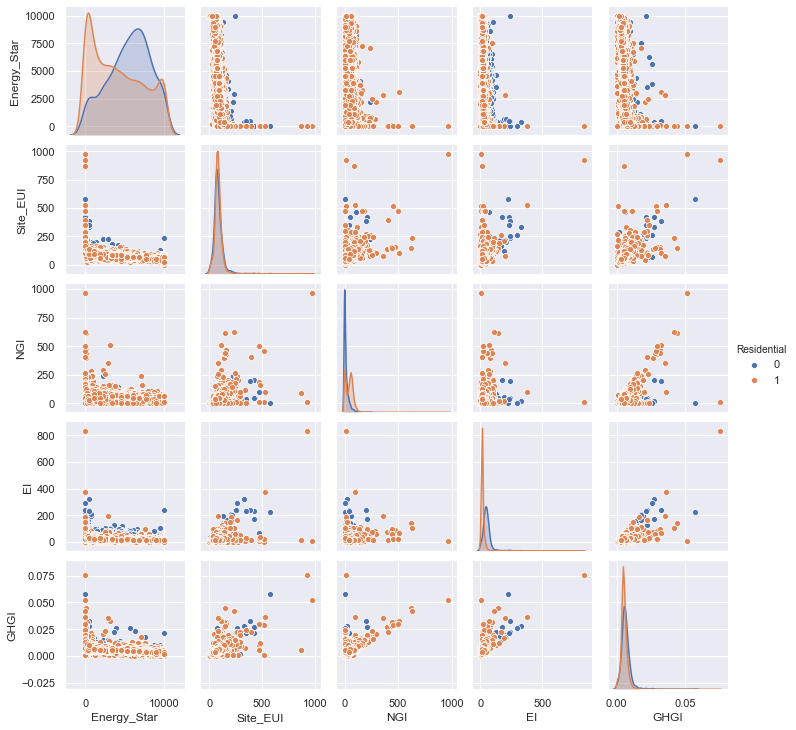

In [9]:
sns.pairplot(df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             size=2,
             hue='Residential')

**We can from the last row in this graph that the relationship between `GHGI` and `Site_EUI`, `NGI`, as well as `EI` is somewhat linear, but the relationship of `GHGI` and `Energy_Star` is less well defined.**

Let's build out our train and test set as well fix our random state (to have repeatable datasets)

In [10]:
from sklearn.model_selection import train_test_split

random_state = 93

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

As we stated earlier we'll start out with a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression Model</a> since it is simple and interpertable. The form of a linear regression the model assumes that the green house gas emission intensity (`GHGI`) labeled $y$, can be expressed a linear combination,

$$ y \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} + \epsilon$$


The $x_{i}$'s are the features for our model (`Energy_Star`, `Residential`, etc.), and the error $\epsilon \sim N(0,\sigma^{2}$) is normally distributed.  We then make a model $h_{\theta}(\textbf{x})$,

$$ 
\begin{align}
h_{\theta}(\textbf{x}) \; &= \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p}  \\
\; &= \; \boldsymbol \theta \cdot \textbf{x}
\end{align}
$$

And estimate the coefficents ($\theta_{i}$) are estimated using ordinary least squares methods.  This leads to the expected value of our preditions being unbiased:

$$ E[ h_{\theta}(\textbf{x})] \; = \; \boldsymbol \theta \cdot \textbf{x}$$

We can easily implement a least squares regression model using Scikit-learn:

In [11]:
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LinearRegression, Ridge
from sklearn.metrics         import r2_score, mean_squared_error

pipe = Pipeline([('scaler',StandardScaler()), 
                  ('reg', LinearRegression())])

model = pipe.fit(X_train, y_train)

We can then evaluate the model performance ($R^{2}$-score) on the test set to *see how much variance in the model we are able to explain* as well as the mean square error (MSE):

In [12]:
y_pred = model.predict(X_test)

# Explained variance score: 
print("R2 score: {}".format(r2_score(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_pred)))

R2 score: 0.6476491751039196
MSE: 2.2264594213905994e-06


We can explain 64.76% of the variance which is pretty good, but definitely leaves room for improvement.  Let's take a look at the coefficients ($\theta_{i}$).

In [14]:
# get the last stage of the pipeline which is the model
reg = pipe.steps[1][1]

# print the coefficients
for coef in zip(X_train.columns, reg.coef_):
    print(coef)
    

('Energy_Star', -0.00012438019591537333)
('Site_EUI', 0.00163961529817878)
('NGI', 0.0002444723997324787)
('EI', 0.001016531188328767)
('Residential', 8.968370025022292e-05)


The model coefficents tell us that features that have continuous feautres an increase in one of their in units results in an increase in the unit of green house emissions that is equal to the coefficent.  We can see that increasing the electricty, energy intensity , and natural gas intensity increases green house gas emissions which makes sense.  Increasing the Energy Star rating of the building tends to decrease the greenhouse gas emissions which makes sense. It also seems that residential buildings tend to emit more green house gases than office space buildings, albiet weakly.

We can measure the p-values for coefficents by using Scikit-Learns's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html">f_regression</a> function.

In [15]:
from sklearn.feature_selection import f_regression

f_stats, pvals = f_regression(X_train, y_train)

for coef in zip(X_train.columns, pvals):
    print("{0}'s p-value : {1}".format(coef[0],coef[1]))

Energy_Star's p-value : 0.0
Site_EUI's p-value : 0.0
NGI's p-value : 1.9403675290317854e-183
EI's p-value : 0.0
Residential's p-value : 6.7888853905324595e-28


**We see that even though the coeficients of the regression model are rather small, their small p-values signifiy that they are still signifcant and should be included in our model.**  Overfitting a linear model can be quite obvious from the coefficients when one of the features has a large absolute value. In our model this does not seem to be the case.  



## 4. Logging Runs With MLflow
-------

Let's add a run to the MLflow experiment that corresponds to this model.  We use the `start_run` function and pass the experiment id along with the name for this run being "Linear Regression"

In [16]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Linear Regression")

We can see that we have an active run that is a [RunInfo](https://www.mlflow.org/docs/latest/python_api/mlflow.entities.html#mlflow.entities.RunInfo) entity that maintains information about the run:

In [17]:
run.info

<RunInfo: artifact_uri='file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns/1/a9000eda0ba14a2abfd5d035749b39f9/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='a9000eda0ba14a2abfd5d035749b39f9', run_uuid='a9000eda0ba14a2abfd5d035749b39f9', start_time=1587935715278, status='RUNNING', user_id='mukeharmon'>

In [18]:
artifact_uri = run.info.artifact_uri

We can add the metrics for our model using the add_metrics

In [19]:
mlflow.log_metric("r2" ,r2_score(y_test, y_pred))
mlflow.log_metric("mse", mean_squared_error(y_test, y_pred))

As well as log the parameters:

In [20]:
params = dict(zip(X_train.columns, reg.coef_))
mlflow.log_params(params)

Let's look at some of the residuals in the continuous features to see if we can find any non-linear patterns that might signal ways improve the model.

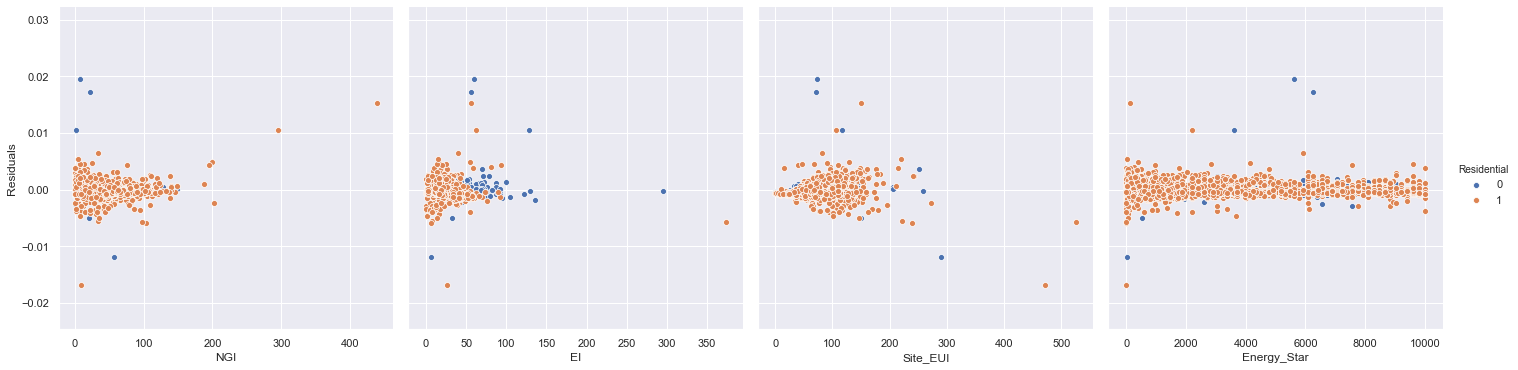

In [21]:
from Plotting_Functions import plot_residuals

f = plot_residuals(X_test = X_test,
                   y_test = y_test,
                   y_pred = y_pred)

We can log those as well using the `log_artifact` method:

In [22]:
f.savefig("resid.png")
mlflow.log_artifact("resid.png")

There are no obvious patterns in the residuals, but at the same time they **do not appear to be normally distributed as the theory says they should be.**  This tells me that we might be able to use a more flexible model to capture the nonlinearities in the relationships.

For the time being let's log the model using the so called [scikit-learn flavor](https://mlflow.org/docs/latest/models.html#scikit-learn-sklearn) and end the run:

In [23]:
import mlflow.sklearn
mlflow.sklearn.log_model(model, "LinearModel")
mlflow.end_run()

We can go to the mlflow web UI to see that the run has been added with it's metrics:

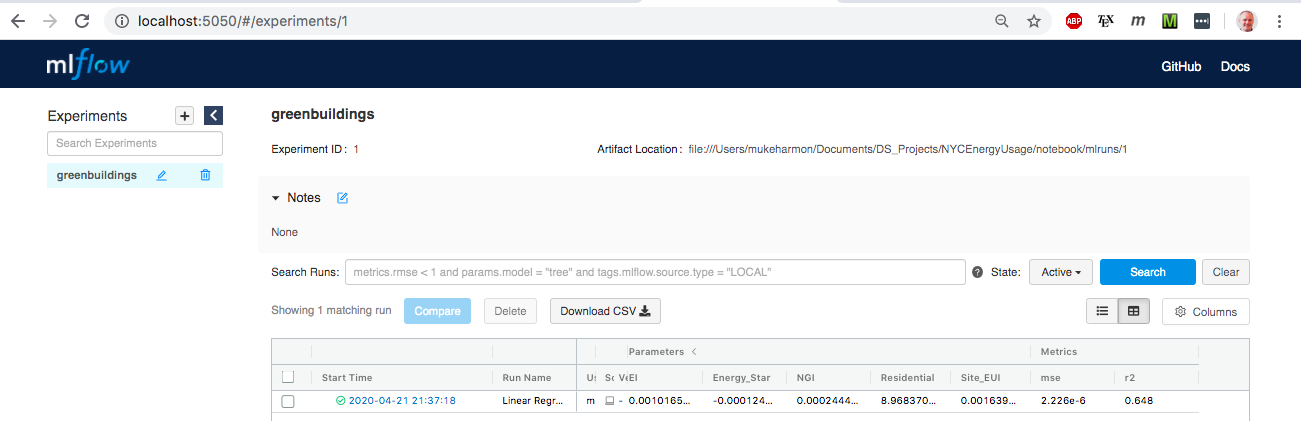

Clicking on the run we can see the parameters, model performance metrics, logged model and artifacts:

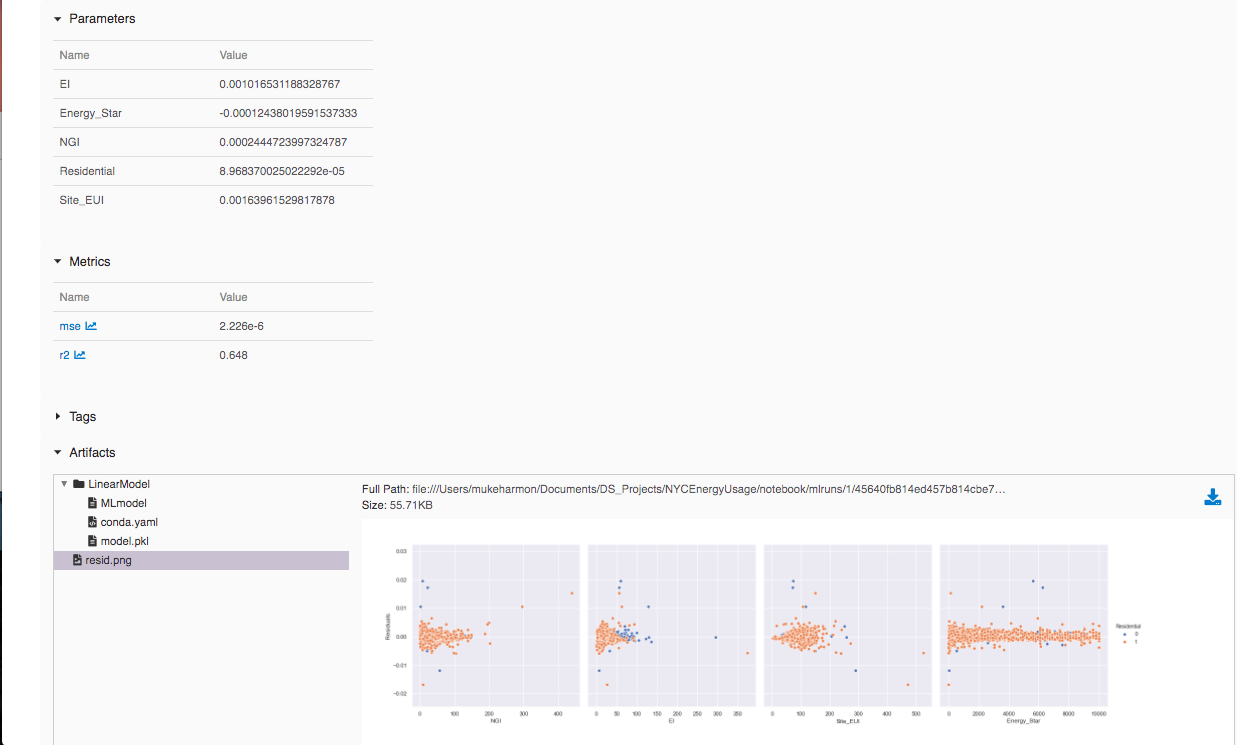

Now, let's say we want to serve this model as a REST API, MLFLOW allows us to do that using the scikit-learn flavors, [save_model](https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.save_model) function:

    mlflow runs list --experiment-id=1
    
    mlflow runs describe 45640fb814ed457b814cbe7598d675b3
    
    mlflow artifacts list -r 45640fb814ed457b814cbe7598d675b3

In [65]:
X_test.head(2).to_json('testdata.json', orient='split')

curl http://0.0.0.0:8000/invocations -H 'Content-Type: application/json' -d testdata.json

In [66]:
import json
with open("testdata.json","r") as f:
    test_json = f.readline()

In [67]:
test_json

'{"columns":["Energy_Star","Site_EUI","NGI","EI","Residential"],"index":[3208,103],"data":[[7744,52.7,45.9641802469,10.1204555556,1],[9,112.2,25.9187489356,29.7707095517,1]]}'

In [74]:
import requests

result = requests.post(url="http://0.0.0.0:5000/invocations",
                       data=test_json,
                       headers={'Content-Type':'application/json'})

In [75]:
result.json()

[0.0036973438673286595, 0.0073271958774853855]

We can see the 


blah blah blah

Let's move on to a more flexible model and hopefully improve our predictions.

### Generalized Additive Models <a class="anchor" id="model-two"></a>

Linear regression is a specific type of generalized linear model.  <a href="https://en.wikipedia.org/wiki/Generalized_linear_model">Generalized lienar models</a> relate the expected outcome of the target variable, $y$, to the model's features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[h_{\theta}(\textbf{x})]) \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

The function $g$ is called the **link** function. For linear regresion the link function is just the identity function, while for logistic regression it is the <a href="https://en.wikipedia.org/wiki/Logit">logit function</a>.

<a href="https://en.wikipedia.org/wiki/Generalized_additive_model">Generalized Additive Models </a>are extension of the generalized addative model that assume that the expected outcome of the target variable $y$ to the features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[h_{\theta}(\textbf{x})]) \; = \; \theta_{0} + f_{1}(x_{1}) + f_{2}(x_{2}) +  \ldots + f_{p}(x_{p}) $$

The basis functions $f_{i}$ can be functions of a parameteric form such as a polynomial, or more general non-parametric functions.  Using basis functions allows for smoother, higher order (more accurate) approximations to the model in parameter space when compared to traditional polynomials.  GAMs therefore allow for more accurate predictions than generalized linear models, however, they still allowing for the model to be interperable.  

We'll use the <a href="https://github.com/dswah/pyGAM">PyGam</a> library which uses penalized <a href="https://en.wikipedia.org/wiki/B-spline">B splines</a> as basis functions. This choice of basis functions allow us to automatically model non-linear relationships without having to manually try out many different transformations on each variable.

We can import the regression GAM model:

In [24]:
from pygam import LinearGAM

We can then fit our model using 10 splines and using a grid search:

In [25]:
pipe2 = Pipeline([('scaler',StandardScaler()),
                  ('gam',  LinearGAM(n_splines=10))])

gam   = pipe2.fit(X_train, y_train)

Evaluating the performance of our model on the test set we find an $R^{2}$ score of:

In [26]:
y_pred = gam.predict(X_test)

# Explained variance score: 
print("R^2 score: {}".format(r2_score(y_test, y_pred)))
print("MSE {}".format(mean_squared_error(y_test, y_pred)))

R^2 score: 0.7743187975786161
MSE 1.4260504129940488e-06


The GAM model results in an improvement in the $R^2$ score and MSE!  We should becareful when we say the model improved our $R^2$ as adding B-splines is equivalent to adding features and [adding features increases $R^{2}$](https://stats.stackexchange.com/questions/133089/why-does-adding-more-terms-into-a-linear-model-always-increase-the-r-squared-val).  However, the improvement in MSE tells me that using a more flexible model like a GAM using B-splines is better able to predict our data when compared to a linear regression model.  Let's take a look at the residuals.

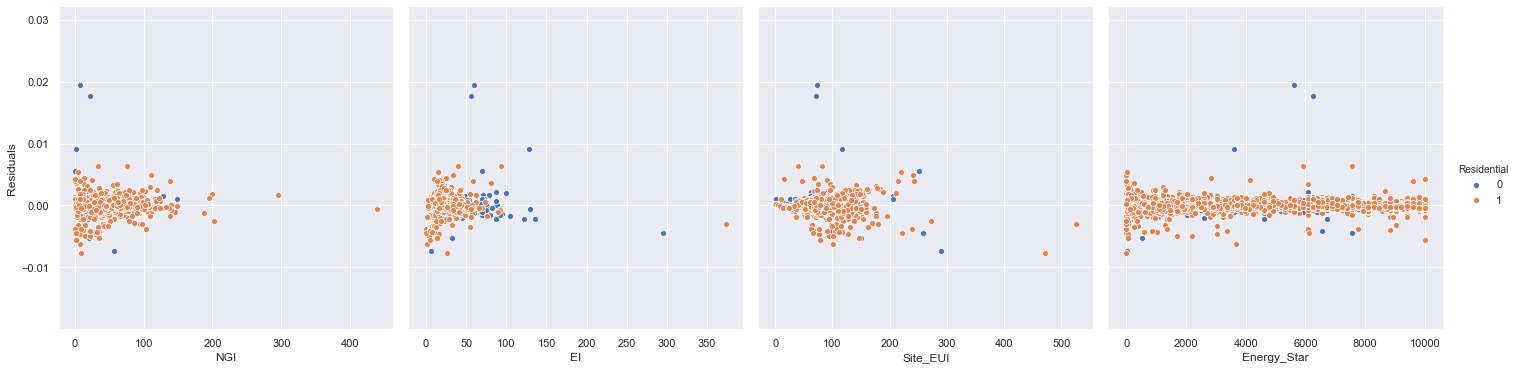

In [32]:
f = plot_residuals(X_test = X_test,
                   y_test = y_test,
                   y_pred = y_pred)

f.savefig("resid.png")

It's a little hard to see the difference between this and regular regression.  

We can explore the effect that the number of splines used in our model has on the performance by training the model on various numbers of splines and plotting the learning curves.  We write a function to train a model  on the training and test set respectively.

In [27]:
def train_gam_full(
    X_train   : pd.DataFrame, 
    y_train   : pd.Series,
    X_test    : pd.DataFrame, 
    y_test    : pd.Series,
    n_splines : int
) -> tuple:
    """ 
    Trains a linear GAM model and returns performance on training and test sets.
    
    :parameters:
    -----------
    X_train (DataFrame) : Training set of features
    y_train (Series)    : Training set target values
    X_test (DataFrame)  : Test set of features
    y_test (Series)     : Test set target values
    n_splines (int)     : The number of splines to use in the GAM
    
    :returns: 
    --------
    The tupple of (MSE) for the training and test set respectively.
    
    """
    model   = LinearGAM(n_splines=n_splines).fit(X_train, y_train)
    y_pred  = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    return mean_squared_error(y_train, y_pred), mean_squared_error(y_test, y_pred2)

We now get the results for our model's learning curve using ideas from functional programing. 

We transform the above function into one that is only dependent on the number of splines using the <a href="https://docs.python.org/2/library/functools.html">partial</a> tool to bind the values the training and test set.  This will allow us to return a function that returns MSE on the training and test set and only depends on the number of splines.

In [28]:
from functools import partial
train_gam      = partial(train_gam_full, X_train, y_train, X_test, y_test)

Now we can define the number of spines we want to train on and then use the <a href="http://book.pythontips.com/en/latest/map_filter.html">map</a> function to get the performance metrics and plot the resulting learning curves:

In [29]:
# defined the 
n_splines = range(5,50)

# get the r2 values
mse_train, mse_test = zip(*map(train_gam, n_splines))

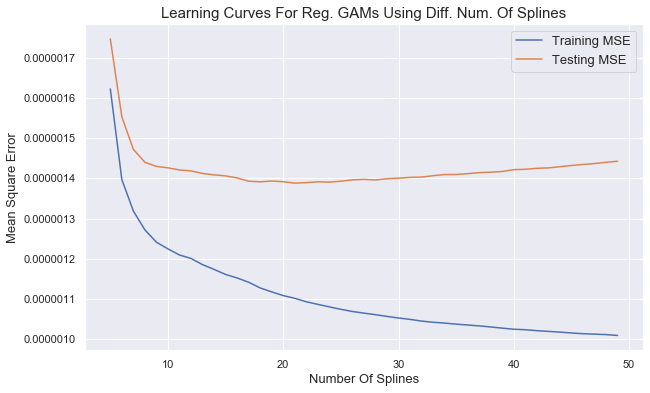

In [30]:
# plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(n_splines, mse_train, label="Training MSE")
plt.plot(n_splines, mse_test,  label="Testing MSE")
plt.ylabel("Mean Square Error",fontsize=13)
plt.xlabel("Number Of Splines",fontsize=13)
# plt.ylim([0.2,0.4])
plt.title("Learning Curves For Reg. GAMs Using Diff. Num. Of Splines", fontsize=15)
plt.legend(fontsize=13)

plt.savefig("GAM_Learning_Curve.png")

Hard to We can see that increasing the number of splines doesnt seem to improve the predictive performance of the model past 10 or 20 splines. Let's log the metrics for the different splines using a nested run:

In [33]:
# create the initial run
with mlflow.start_run(experiment_id=exp_id, run_name="GAMS ", nested=True):
    
    for n_spline, mse in zip(n_splines, mse_test):
        
        # create the nested run with the name being dependent on the 
        # number of splines
        with mlflow.start_run(experiment_id=exp_id, 
                              run_name="GAM w/ n_Spline = {}".format(n_spline), 
                              nested=True):
        
            mlflow.log_metric("mse",mse)
            mlflow.log_param("n_spline",n_spline)
    
    # log the 
    mlflow.log_artifact("GAM_Learning_Curve.png")
    mlflow.log_artifact("resid.png")
    mlflow.log_metrics({"r2":r2_score(y_test, y_pred),
                        "mse":mean_squared_error(y_test, y_pred)})

In [73]:
And see all the runs under the nested runs:

SyntaxError: invalid syntax (<ipython-input-73-0d86cdd120eb>, line 1)

In [65]:
pygam_env = {
    'channels': ['defaults', 'conda-forge'],
    'dependencies': [
      'python=3.6.6',
      'scikit-learn={}'.format(sklearn.__version__),
      'cloudpickle={}'.format(cloudpickle.__version__),
      'pip'],
      'pip': [
        'pygam=={}'.format(pygam.__version__),
        'mlflow'
    ],
    'name': 'pygam_env'
}



In [ ]:
mlflow.sklearn.save_model(gam, "GAM_Model", conda_env=pygam_env)


I had to re-arrange the `GAM_Model/conda.yaml` to be correct by hand, but then running:
    
    conda models server -m GAM_Model

starts off looking like:

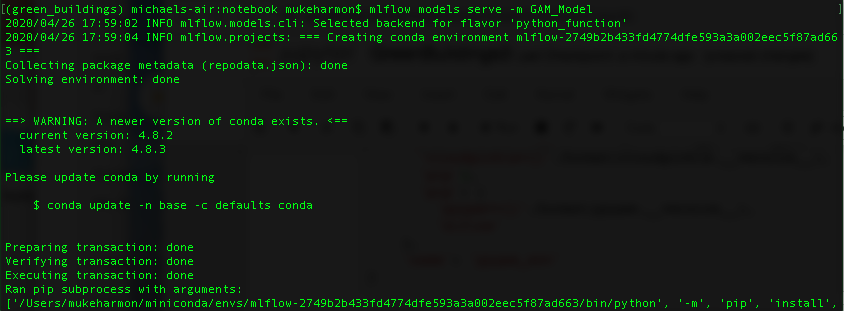

In [53]:
gam2 = mlflow.sklearn.load_model('Gam_Model2')

In [54]:
gam2.predict(X_test)

array([0.00313333, 0.00736628, 0.00650413, ..., 0.00218808, 0.02853807,
       0.00681724])

So in order to improve the predictive ability we'll need to turn to a different model.

###  XGBoost Regression Trees <a class="anchor" id="model-three"></a>

Let's try another model to see if we cant improve our $R^2$ score and MSE for our model. One model that performs quite well is the [XGBoost Boosted Regression Tree](https://xgboost.readthedocs.io/en/latest/).  XGBoost is a nonlinear model based on decision trees using gradient boosting and is one of the best performing machine learning models avaiable.  It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. Lets import our XGBoost Regressor and then run a small grid search using cross-valiation to find the optimal parameter values for our model:

In [71]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# define the parameter values
paramters = {"n_estimators":[25,50,100,200],
             "max_depth"   :[3,5,10],
             "loss"        :["ls", "lad"]
}

# defind the grid search and optimization metric
grid = GridSearchCV(estimator=XGBRegressor(),
                    param_grid=paramters,
                    scoring="r2",
                    cv=5,
                    n_jobs=-1)

# perform the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

Now that we have the best model from our grid search over the trainin set let see how it performs on the test set:

In [72]:
y_pred = grid.predict(X_test)

# Explained variance score: 
print("R^2 score: {}".format(r2_score(y_test, y_pred)))
print("MSE {}".format(mean_squared_error(y_test, y_pred)))

R^2 score: 0.7761477343001326
MSE 1.4144935977206672e-06


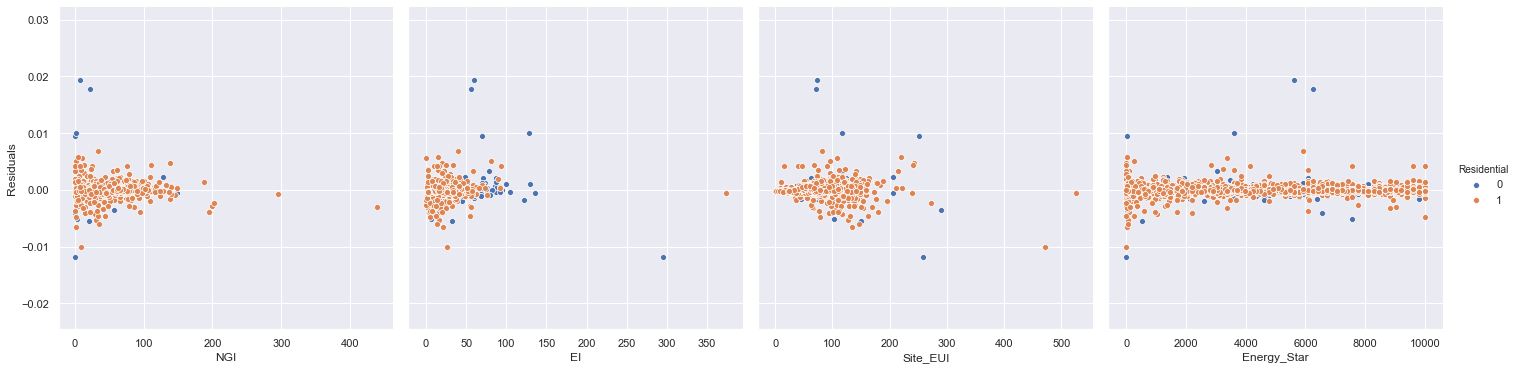

In [73]:
# compute the residuals
resid = (y_test - y_pred).to_frame()\
                         .rename(columns={"GHGI":"Residuals"})

# left join them to the original features
x_resid = X_test.merge(resid, left_index=True, right_index=True)

# plot the residuals
sns.pairplot(x_resid, 
             x_vars=['NGI','EI','Site_EUI','Energy_Star'], 
             y_vars='Residuals', 
             hue='Residential',
             kind = 'scatter',
             size=5, 
             dropna=True)

Again a definite improvement in the $R^2$ score!  While we have improved our prediction capabilities, one draw back to more complex models like Gradient Boosted Regressors is that they are less interperable.  Despite this draw back, Scikit-learn still allows to the find the relative importance of the features on the outcome of the model:

In [74]:
model = grid.best_estimator_
for coef in zip(X_train.columns, model.feature_importances_):
    print(coef)

('Energy_Star', 0.03286382)
('Site_EUI', 0.4422697)
('NGI', 0.26643634)
('EI', 0.24186888)
('Residential', 0.016561199)


In [125]:
# mlflow.get_run("XGBoostRegressor")

In [82]:
mlflow.start_run(
    experiment_id=exp_id,
    run_name="XGBoostRegressor",
    nested=True
)
cv_results = grid.cv_results_

for params, metric, rank in zip(cv_results['params'],
                                cv_results['mean_test_score'],
                                cv_results["rank_test_score"]):

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metric("r2",metric)




In [84]:
mlflow.log_params(grid.best_params_)
mlflow.log_metrics({"r2":r2_score(y_test, y_pred),
                   "mse":mean_squared_error(y_test, y_pred)})

{'loss': 'ls', 'max_depth': 3, 'n_estimators': 100}

In [121]:
from mlflow import xgboost as mlflow_xgboost

In [122]:
mlflow_xgboost.save_model(grid.best_estimator_, "XGBModel")

In [123]:
mlflow.end_run()

    mlflow runs list --experiment-id=1
    
    mlflow runs describe 45640fb814ed457b814cbe7598d675b3
    
    mlflow artifacts list -r 45640fb814ed457b814cbe7598d675b3

` mlflow models serve --model-uri=`pwd`/XGBModel`

In [129]:
grid.best_estimator_.predict(X_test.head(2))

array([0.00314277, 0.00720516], dtype=float32)

The most important features for predicting green house gas emissions are the energy star score followed by tnatural gas intensity and the electicity intensity.  The zipcode and the year built have the least importance, which from our analysis above makes sense.

That's enough modeling for now! Overall we were able to come with a model that explains over 75% of the variance in the test set data.  Not bad!

--------------
## Conclusions
--------------

In addition, we investigated creating a predictive model of green house gas emissions for multi-family buildings in New York City.  The highest performing model was a gradient boosted tree model that had $R^2$ value of 0.76.  The most important features for predicting green house gas emissions in this model are the natural gas intensity followed by the energy start scored and the electicity intensity. The zipcode and the year built have the least importance, which from our analysis above makes sense.